#### Samarth Singh - DS 5559 Exploratory Text Analytics - 6 May 2019

# Final Project Synopsis

This notebook contains the entire  process for my final project. It starts from F0 where all the text-documents related to a particular fossil fuel are read and then further broken down into paras,sentences and tokens. Correspondingly Tokens and Vocab tables are made and then we perform Sentiment Analysis on it. 

# Configuration

In [36]:
base_path = 'C:/Users/samar/OneDrive/Desktop/UVA/Stochastic Hydrology'
src_dir_coal = base_path + '/Data_Final/Coal_Final'
src_dir_gas = base_path + '/Data_Final/Gas_Final'
para_pat = r'\n\n+'
token_pat = r'([\W_]+)'
db_file = 'bios.db'

In [37]:
extra_stopwords = """
us rest went least would much must long one like much say well without though yet might still upon
done every rather particular made many previous always never thy thou go first oh thee ere ye came
almost could may sometimes seem called among another also however nevertheless even way one two three
ever put since became used need altogether likewise usual understand finally generally
""".strip().split()

In [38]:
OHCO = ['doc_id', 'para_id', 'sent_id', 'token_id']
DOCS = OHCO[:1]
#SUBJS = OHCO[:2]
#BTYPE = OHCO[:3] # a for autobiography, b otherwise
PARAS = OHCO[:2]
SENTS = OHCO[:3]

# Libraries

In [39]:
import glob
import re

import pandas as pd
from numpy.random import randint
import sys; sys.path.append(base_path)
import textman as tx
import sqlite3
import numpy as np

from sklearn.preprocessing import normalize
from sklearn.neighbors import KernelDensity as KDE
from sklearn.preprocessing import scale
import scipy.fftpack as fftpack

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import display, HTML

import nltk
from nltk.tokenize import RegexpTokenizer
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('tagsets')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\samar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\samar\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\samar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package tagsets to
[nltk_data]     C:\Users\samar\AppData\Roaming\nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\samar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Pragmas

In [40]:
%matplotlib inline
sns.set()
plt.style.use('fivethirtyeight')

# Process

Imported all the text-files and created the corpus.

In [41]:
files = glob.glob(src_dir_coal+'/*.txt')
corpus = pd.DataFrame([f.replace('.txt','').split('/')[-1].split('-') for f in files], 
                    columns=['a','doc_id'])
#corpus['bio_type'] = corpus['bio_type'].map(lambda x: x.lstrip('Bios\\'))
#corpus = corpus[BTYPE]
corpus['doc_content'] = [open(f, 'r', encoding='ISO-8859-1').read() for f in files]
#stuff = corpus[['subject_type','subject']]
#stuff.to_csv('stuff.csv', index = True, header = True)
#corpus.head()
#files
corpus=corpus.drop(['a'], axis=1)
corpus

,doc_id,doc_content
0,1,ï»¿This article analyzes the coalmining opposi...
1,10,ï»¿Engaging with Australiaâs nascent coal se...
2,11,ï»¿Bangladesh is planning to build a series of...
3,2,ï»¿This article employs a power structure rese...
4,3,ï»¿The U.S. coal industry has experienced econ...
5,4,ï»¿This paper explores the socio-technical ima...
6,5,ï»¿Greenhouse gas emissions are stagnating in ...
7,6,ï»¿The young Republic of Kosovo sits atop the ...
8,7,"ï»¿Energy is fundamental to human existence, a..."
9,8,ï»¿Energy transitions involve long-term struct...


### Set OHCO Index

In [42]:
try:
    corpus = corpus.set_index(DOCS)
    corpus = corpus.sort_index()
except KeyError:
    pass

### Create Stopword List

In [43]:
sw = nltk.corpus.stopwords.words('english') + extra_stopwords

### Fix some characters to improve tokenization

In [44]:
corpus.doc_content = corpus.doc_content.str.replace(r"(—|-)", ' \g<1> ')

## Documents to Paragraphs

In [45]:
paras = corpus.doc_content.str.split(para_pat, expand=True)\
    .stack()\
    .to_frame()\
    .rename(columns={0:'para_str'})
paras.index.names = PARAS
#paras.index.names = ['doc','para_num']
paras.para_str = paras.para_str.str.strip()
paras.para_str = paras.para_str.str.replace(r'\n', ' ')
paras.para_str = paras.para_str.str.replace(r'\s+', ' ')
paras = paras[~paras.para_str.str.match(r'^\s*$')]

## Paragraphs to Sentences

In [46]:
sents = paras.para_str\
    .apply(lambda x: pd.Series(nltk.sent_tokenize(x)))\
    .stack()\
    .to_frame()\
    .rename(columns={0:'sent_str'})
sents.index.names = SENTS

## Sentences to Tokens with POS tagging

In [47]:
tokenizer = RegexpTokenizer(r'\w+')

In [48]:
tokens = sents.sent_str\
    .apply(lambda x: pd.Series(nltk.pos_tag(tokenizer.tokenize(x))))\
    .stack()\
    .to_frame()\
    .rename(columns={0:'pos_tuple'})
tokens.index.names = OHCO
tokens['pos'] = tokens.pos_tuple.apply(lambda x: x[1])
tokens['token_str'] = tokens.pos_tuple.apply(lambda x: x[0])
tokens = tokens.drop('pos_tuple', 1)

### Tag punctuation and numbers

In [49]:
tokens['punc'] = tokens.token_str.str.match(r'^[\W_]*$').astype('int')
tokens['num'] = tokens.token_str.str.match(r'^.*\d.*$').astype('int')

In [50]:
tokens.sample(15)

pos     token_str  punc  num
doc_id para_id sent_id token_id                              
6      22      4       10         CC           and     0    0
5      8       0       11         IN          with     0    0
2      31      1       12        NNP       Chamber     0    0
       35      10      36         NN       process     0    0
1      31      2       13         IN            on     0    0
       34      6       7         NNP          NGOs     0    0
10     24      6       5          IN            of     0    0
8      33      9       18         VB          have     0    0
               3       5          NN         night     0    0
1      39      15      5          IN            of     0    0
2      12      2       13        NNS  associations     0    0
10     6       4       14         JJ       eminent     0    0
5      26      3       22         JJ          same     0    0
10     21      1       0         NNP          Coal     0    0
6      3       4       1         NNS     practices     0    0

## Extract vocab with minimal normalization

In [51]:
WORDS = (tokens.punc == 0) & (tokens.num == 0)
tokens.loc[WORDS, 'term_str'] = tokens.token_str.str.lower().str.replace(token_pat, '')   
#.str.replace(r'["_*.\']', '')
vocab = tokens[tokens.punc == 0].term_str.value_counts().to_frame()\
    .reset_index()\
    .rename(columns={'index':'term_str', 'term_str':'n'})
vocab = vocab.sort_values('term_str').reset_index(drop=True)
vocab.index.name = 'term_id'

### Get priors for Vocab

In [52]:
vocab['p'] = vocab.n / vocab.n.sum()

### Add stems

In [53]:
stemmer = nltk.stem.porter.PorterStemmer()
vocab['port_stem'] = vocab.term_str.apply(lambda x: stemmer.stem(x))

### Define stopwords

In [54]:
stopwords = set(nltk.corpus.stopwords.words('english') + extra_stopwords)

In [55]:
sw = pd.DataFrame({'x':1}, index=stopwords)
vocab['stop'] = vocab.term_str.map(sw.x).fillna(0).astype('int')

### Add term_ids to Tokens

In [56]:
tokens['term_id'] = tokens['term_str'].map(vocab.reset_index()\
    .set_index('term_str').term_id).fillna(-1).astype('int')

In [57]:
vocab.sample(20)

,term_str,n,p,port_stem,stop
term_id,,,,,
7586,underway,3,0.000037,underway,0
5167,pace,2,0.000024,pace,0
3721,indirect,9,0.000110,indirect,0
6113,repeal,3,0.000037,repeal,0
971,capitalists,3,0.000037,capitalist,0
4273,lineman,1,0.000012,lineman,0
4824,neutral,3,0.000037,neutral,0
1572,contractor,1,0.000012,contractor,0
1717,crucially,1,0.000012,crucial,0


### Delete extra tables

In [58]:
del(paras)
del(sents)
del(sw)
tokens

pos    token_str  punc  num     term_str  \
doc_id para_id sent_id token_id                                              
1      0       0       0           NN            ï     0    0            ï   
                       1           DT         This     0    0         this   
                       2           NN      article     0    0      article   
                       3          VBZ     analyzes     0    0     analyzes   
                       4           DT          the     0    0          the   
                       5          VBG   coalmining     0    0   coalmining   
                       6           NN   opposition     0    0   opposition   
                       7           IN           in     0    0           in   
                       8           DT          the     0    0          the   
                       9          NNP        Czech     0    0        czech   
                       10         NNP     Republic     0    0     republic   
                       11          DT            a     0    0            a   
                       12          NN      country     0    0      country   
                       13          IN         with     0    0         with   
                       14          JJ  substantial     0    0  substantial   
                       15          JJ        brown     0    0        brown   
                       16          NN         coal     0    0         coal   
                       17          NN   production     0    0   production   
                       18          JJ         high     0    0         high   
                       19          NN   dependency     0    0   dependency   
                       20          IN           on     0    0           on   
                       21          DT         this     0    0         this   
                       22          NN         fuel     0    0         fuel   
                       23          JJ      massive     0    0      massive   
                       24         NNS      exports     0    0      exports   
                       25          IN           in     0    0           in   
                       26          NN         form     0    0         form   
                       27          IN           of     0    0           of   
                       28          NN  electricity     0    0  electricity   
                       29          CC          and     0    0          and   
...                               ...          ...   ...  ...          ...   
9      16      8       6           NN         hope     0    0         hope   
                       7           IN         that     0    0         that   
                       8           NN     research     0    0     research   
                       9           IN           in     0    0           in   
                       10          DT          the     0    0          the   
                       11         NNP      Coupled     0    0      coupled   
                       12         NNP        Human     0    0        human   
                       13          CC          and     0    0          and   
                       14         NNP      Natural     0    0      natural   
                       15        NNPS      Systems     0    0      systems   
                       16         NNP        CHANS     0    0        chans   
                       17          CC          and     0    0          and   
                       18         NNP        Socio     0    0        socio   
                       19          JJ   ecological     0    0   ecological   
                       20         NNP      Systems     0    0      systems   
                       21         NNP          SES     0    0          ses   
                       22         NNS   traditions     0    0   traditions   
                       23          MD         will     0    0         will   
                       24          RB      further     0

In [59]:
# Developed in other notebook
lex_db = './lexicons.db'

OHCO = [ 'para_id', 'sent_id', 'token_id']
#CHAPS = OHCO[:1]
PARAS = OHCO[:1]
SENTS = OHCO[:2]

# emo = 'bing_sentiment'
emo = 'syu_sentiment'

# For KDE
kde_kernel = 'gaussian'
# kde_bandwidth = 100
kde_samples = 1000

In [60]:
with sqlite3.connect(lex_db) as db:
    combo = pd.read_sql('SELECT * FROM combo', db, index_col='term_str')
combo.head()

,nrc_anger,nrc_anticipation,nrc_disgust,nrc_fear,nrc_joy,nrc_negative,nrc_positive,nrc_sadness,nrc_surprise,nrc_trust,bing_negative,bing_positive,bing_sentiment,syu_sentiment,gi_sentiment
term_str,,,,,,,,,,,,,,,
abandon,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,-0.75,-1.0
abandoned,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,-0.50,NaN
abandoner,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.25,NaN
abandonment,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,-0.25,-1.0
abandons,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.00,NaN


In [61]:
emo_cols = combo.columns

In [62]:
FIG = dict(figsize=(25, 5), legend=True, fontsize=14, rot=45)
FIG

{'figsize': (25, 5), 'legend': True, 'fontsize': 14, 'rot': 45}

# Analysis

### Merge sentiment lexicon with vocab

In [63]:
tokens = tokens.join(combo, on='term_str', how='left')

In [64]:
tokens.head()

pos token_str  punc  num  term_str  term_id  \
doc_id para_id sent_id token_id                                                
1      0       0       0          NN         ï     0    0         ï     8071   
                       1          DT      This     0    0      this     7317   
                       2          NN   article     0    0   article      467   
                       3         VBZ  analyzes     0    0  analyzes      323   
                       4          DT       the     0    0       the     7275   

                                 nrc_anger  nrc_anticipation  nrc_disgust  \
doc_id para_id sent_id token_id                                             
1      0       0       0               NaN               NaN          NaN   
                       1               NaN               NaN          NaN   
                       2               NaN               NaN          NaN   
                       3               NaN               NaN          NaN   
                       4               NaN               NaN          NaN   

                                 nrc_fear  ...  nrc_negative  nrc_positive  \
doc_id para_id sent_id token_id            ...                               
1      0       0       0              NaN  ...           NaN           NaN   
                       1              NaN  ...           NaN           NaN   
                       2              NaN  ...           NaN           NaN   
                       3              NaN  ...           NaN           NaN   
                       4              NaN  ...           NaN           NaN   

                                 nrc_sadness  nrc_surprise  nrc_trust  \
doc_id para_id sent_id token_id                                         
1      0       0       0                 NaN           NaN        NaN   
                       1                 NaN           NaN        NaN   
                       2                 NaN           NaN        NaN   
                       3                 NaN           NaN        NaN   
                       4                 NaN           NaN        NaN   

                                 bing_negative  bing_positive  bing_sentiment  \
doc_id para_id sent_id token_id                                                 
1      0       0       0                   NaN            NaN             NaN   
                       1                   NaN            NaN             NaN   
                       2                   NaN            NaN             NaN   
                       3                   NaN            NaN             NaN   
                       4                   NaN            NaN             NaN   

                                 syu_sentiment  gi_sentiment  
doc_id para_id sent_id token_id                               
1      0       0       0                   NaN           NaN  
                       1                   NaN           NaN  
                       2                   NaN           NaN  
                       3                   NaN           NaN  
                       4                   NaN           NaN  

[5 rows x 21 columns]

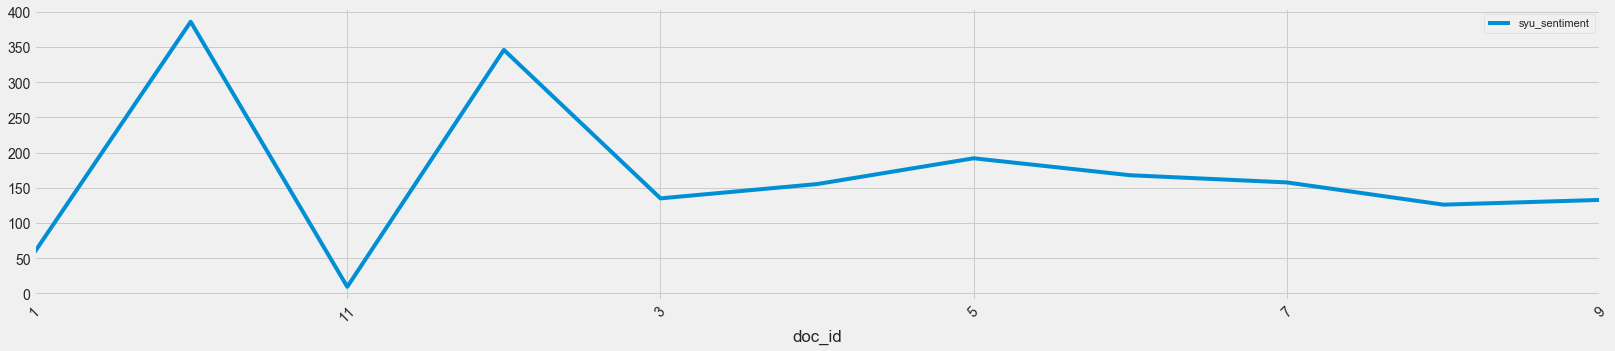

In [65]:
tokens.groupby(DOCS)[emo].sum().plot(**FIG)
tokens[emo_cols] = tokens[emo_cols].fillna(0)
#syu_sentiment seems to be pretty positive for coal

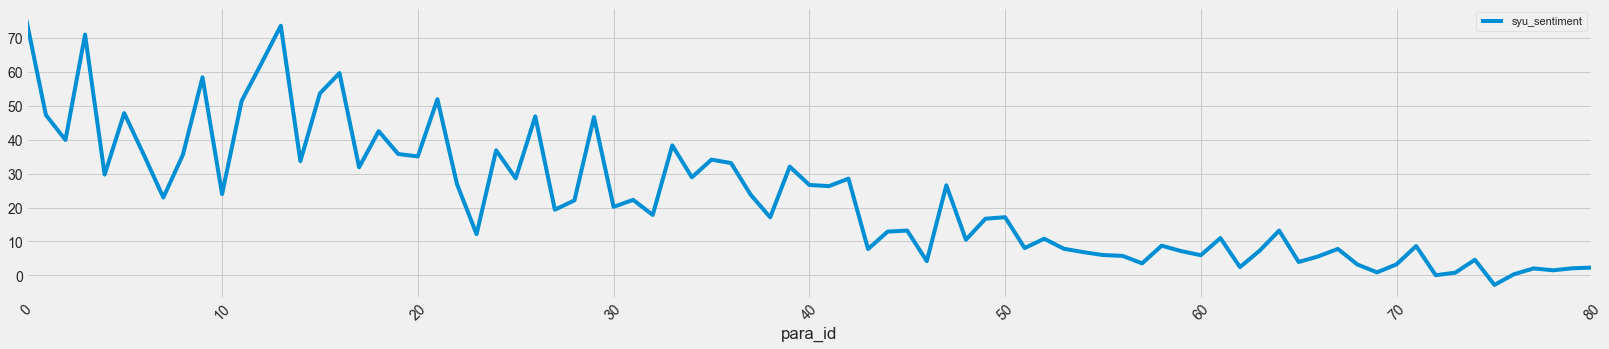

In [66]:
tokens.groupby(PARAS)[emo].sum().plot(**FIG)
tokens[emo_cols] = tokens[emo_cols].fillna(0)
#conclusion paras seem to be more dull

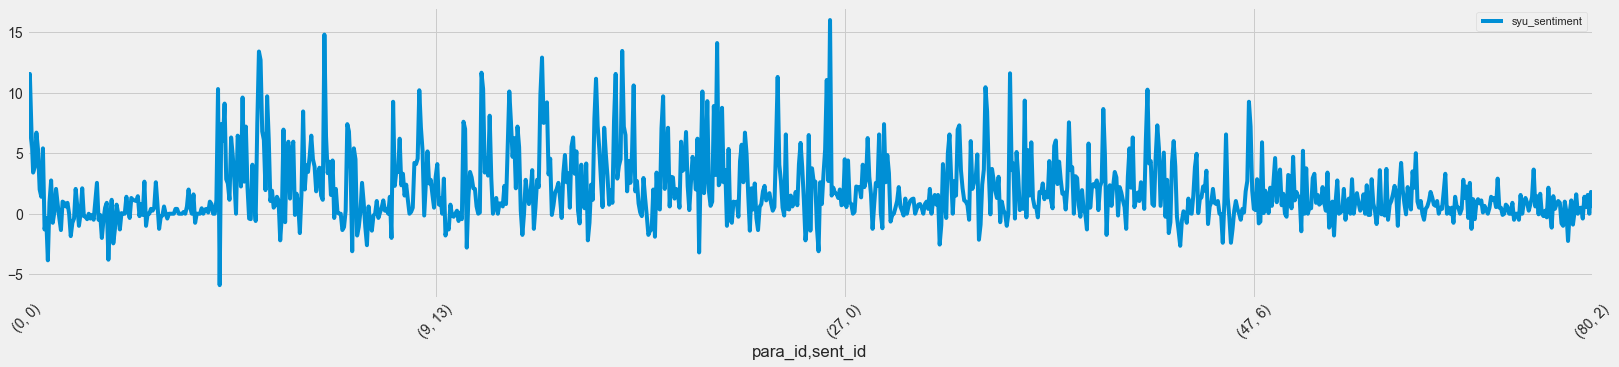

In [67]:
by_sent = tokens.groupby(SENTS)[emo_cols].sum()
max_x = by_sent.shape[0]
xticks = list(range(0, max_x, 250))
xticks.append(max_x - 1)
by_sent[emo].plot(**FIG, xticks=xticks)

In [68]:
tokens['html'] =  tokens.apply(lambda x: 
                               "<span class='sent{}'>{}</span>".format(int(np.sign(x[emo])), x.token_str), 1)
tokens['html'].head()
#tokens

doc_id  para_id  sent_id  token_id
1       0        0        0                  <span class='sent0'>ï</span>
                          1               <span class='sent0'>This</span>
                          2            <span class='sent0'>article</span>
                          3           <span class='sent0'>analyzes</span>
                          4                <span class='sent0'>the</span>
Name: html, dtype: object

In [69]:
by_sent['sent_str'] = tokens.groupby(SENTS).term_str.apply(lambda x: x.str.cat(sep=' '))
by_sent['html_str'] = tokens.groupby(SENTS).html.apply(lambda x: x.str.cat(sep=' '))

In [70]:
by_sent[['sent_str', 'html_str']].head()

sent_str  \
para_id sent_id                                                      
0       0        ï this article analyzes the coalmining opposit...   
        1        in the czech government established so called ...   
        2        the existence of these limits sparked a confli...   
        3        this article focuses on the discursive level o...   
        4        based on semi structured interviews conducted ...   

                                                          html_str  
para_id sent_id                                                     
0       0        <span class='sent0'>ï</span> <span class='sent...  
        1        <span class='sent0'>In</span> <span class='sen...  
        2        <span class='sent0'>The</span> <span class='se...  
        3        <span class='sent0'>This</span> <span class='s...  
        4        <span class='sent0'>Based</span> <span class='...

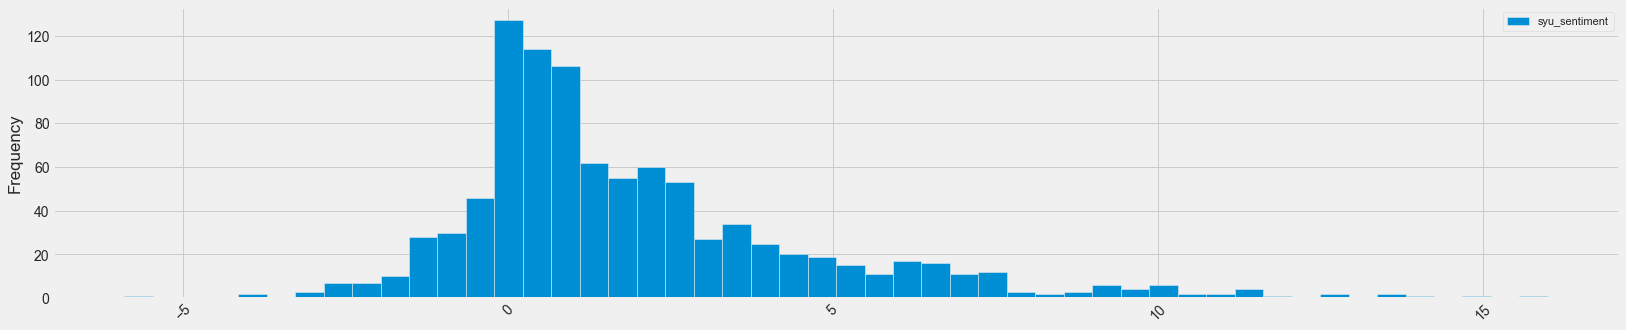

In [71]:
by_sent[emo].plot.hist(**FIG, bins=50)

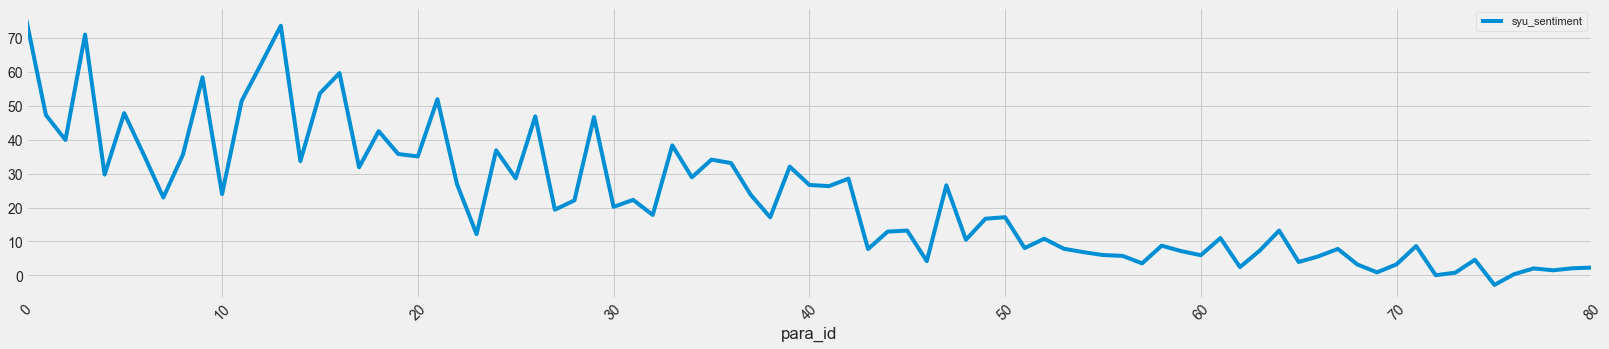

In [72]:
tokens.groupby(PARAS)[emo].sum().plot(**FIG)
tokens[emo_cols] = tokens[emo_cols].fillna(0)

### Look at a sample of sentences

In [73]:
rows = []
for idx in by_sent.sample(10).index:
    
    valence = round(by_sent.loc[idx, emo], 4)     
    t = 0
    if valence > t: color = '#ccffcc'
    elif valence < t: color = '#ffcccc'
    else: color = '#f2f2f2'
    z=0
    rows.append("""<tr style="background-color:{0};padding:.5rem 1rem;font-size:110%;">
    <td>{1}</td><td>{3}</td><td width="400" style="text-align:left;">{2}</td>
    </tr>""".format(color, valence, by_sent.loc[idx, 'html_str'], idx))
    
display(HTML('<style>#sample1 td{font-size:120%;vertical-align:top;} .sent-1{color:red;font-weight:bold;} .sent1{color:green;font-weight:bold;}</style>'))
display(HTML('<table id="sample1"><tr><th>Sentiment</th><th>ID</th><th width="600">Sentence</th></tr>'+''.join(rows)+'</table>'))

In [74]:
xticks = [0]
xticks += by_sent[emo].reset_index().sort_values(emo).head(7).index.values.tolist()
xticks += by_sent[emo].reset_index().sort_values(emo).tail(7).index.values.tolist()
xticks += [by_sent.shape[0] - 1]

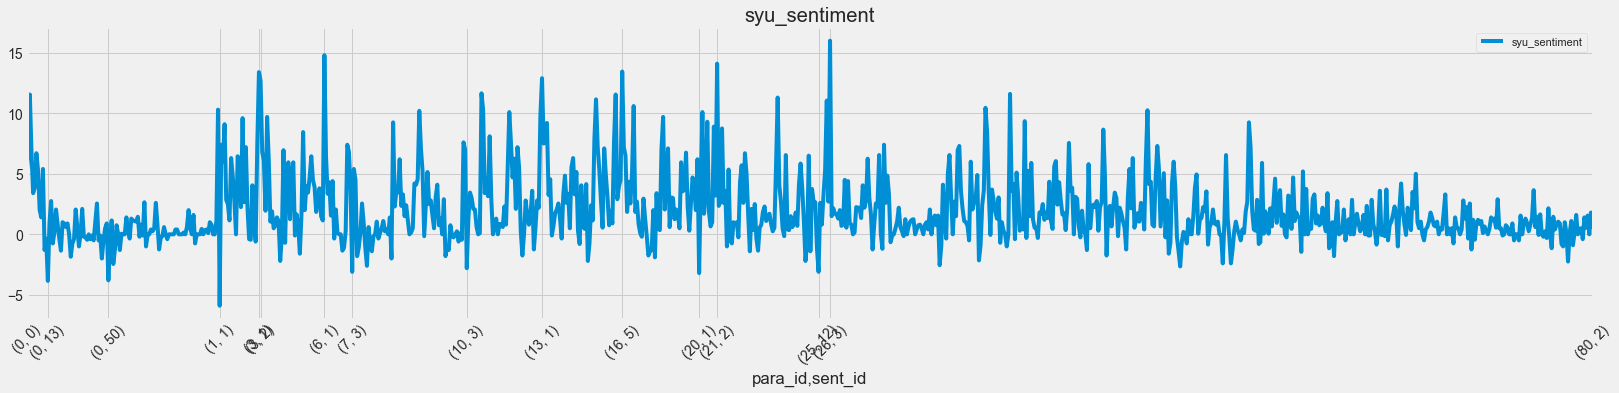

In [75]:
by_sent[emo].plot(**FIG, xticks=xticks, title=emo)

As can be seen, in the paper valence was close to zero, here it is quite positive.

<img src="Average_valence.png" width="900"/>

In [76]:
by_sent.iloc[xticks][emo].sort_index().to_frame()
#Clearly the entire sentiment is positive.
#Data is pretty different from the original corpus.
#Maybe in scientific literature, Coal is talked about in positive.

syu_sentiment
para_id sent_id               
0       0                 4.85
        13               -3.85
        50               -3.80
1       1                -5.90
3       1                13.40
        2                12.70
6       1                14.80
7       3                -3.10
10      3                -2.80
13      1                12.90
16      5                13.45
20      1                -3.20
21      2                14.10
25      12               -3.10
26      3                16.00
80      2                 0.50

### Inspect Positives

In [92]:
by_sent.sort_values(emo, ascending=False)[[emo,'sent_str']].head(20)

,,syu_sentiment,sent_str
para_id,sent_id,,
26,3,16.00,â look this planet is going to cook itself thi...
6,1,14.80,the movement was promptly listed as an extremi...
21,2,14.10,the use of clean coal technologies is not cons...
16,5,13.45,nowhere is the link between knowledge producti...
3,1,13.40,the legal form of a governmental decree means ...
13,1,12.90,to achieve that local magazines have been issu...
3,2,12.70,reserves proven to be located beyond the limit...
11,0,11.65,last the mining companies have little impetus ...
34,0,11.60,the determination to resist is further cemente...


### Inspect Negatives

In [78]:
by_sent.sort_values(emo, ascending=True)[[emo,'sent_str']].head(20)
#negative sentiments magnitudes are clearly less.

syu_sentiment  \
para_id sent_id                  
1       1                -5.90   
0       13               -3.85   
        50               -3.80   
20      1                -3.20   
7       3                -3.10   
25      12               -3.10   
10      3                -2.80   
43      7                -2.65   
7       12               -2.60   
30      0                -2.55   
0       53               -2.45   
46      6                -2.40   
        1                -2.40   
75      4                -2.25   
4       0                -2.20   
25      4                -2.20   
14      12               -2.20   
32      5                -2.15   
0       46               -2.00   
8       1                -2.00   

                                                          sent_str  
para_id sent_id                                                     
1       1        movements responding to this situation emerged...  
0       13       on the other hand any projects extending coal ...  
        50       the normative critique has demonstrated how th...  
20      1        â if you look at per capita emissions of the p...  
7       3        at the same time people at the local level hav...  
25      12       they had run into difficulties when her husban...  
10      3        in this context the unemployment narrative pus...  
43      7        the climate change framing typically focuses o...  
7       12       as we go on to show in section this imaginary ...  
30      0        the only overarching agreement in this frame s...  
0       53       more broadly the opposition supposedly consist...  
46      6        this is emphasized further in the injustice fr...  
        1        the role of the university in this space inclu...  
75      4        sqd framings at the same time are able to pres...  
4       0        the first clashes of the conflict occurred bet...  
25      4        â at that time we were afraid that the organiz...  
14      12       the emergence of these alternative and more am...  
32      5        â a lot of energy was invested to build links ...  
0       46       however the literature on local opposition has...  
8       1        â the czech public does not see the destructio...

## Apply Transforms

### Adapt Jockers' original FFT function 

Fast Fourier Transform. See https://rdrr.io/cran/syuzhet/man/get_transformed_values.html

In [93]:
def get_transformed_values(raw_values, low_pass_size = 2, x_reverse_len = 100,  padding_factor = 2, scale_values = False, scale_range = False):

    if low_pass_size > len(raw_values):
        sys.exit("low_pass_size must be less than or equal to the length of raw_values input vector")

    raw_values_len = len(raw_values)
    padding_len = raw_values_len * padding_factor

    # Add padding, then fft
    values_fft = fftpack.fft(raw_values, padding_len)
    low_pass_size = low_pass_size * (1 + padding_factor)
    keepers = values_fft[:low_pass_size]

    # Preserve frequency domain structure
    modified_spectrum = list(keepers) \
        + list(np.zeros((x_reverse_len * (1+padding_factor)) - (2*low_pass_size) + 1)) \
        + list(reversed(np.conj(keepers[1:(len(keepers))])))
    
    
    # Strip padding
    inverse_values = fftpack.ifft(modified_spectrum)
    inverse_values = inverse_values[:x_reverse_len]

#     transformed_values = np.real(tuple(inverse_values))
    transformed_values = np.real(inverse_values)
    return transformed_values

In [80]:
FFTCFG = dict(
    low_pass_size = 3,
    x_reverse_len = 100,
    padding_factor = 2
)
X = get_transformed_values(by_sent[emo].values, **FFTCFG)

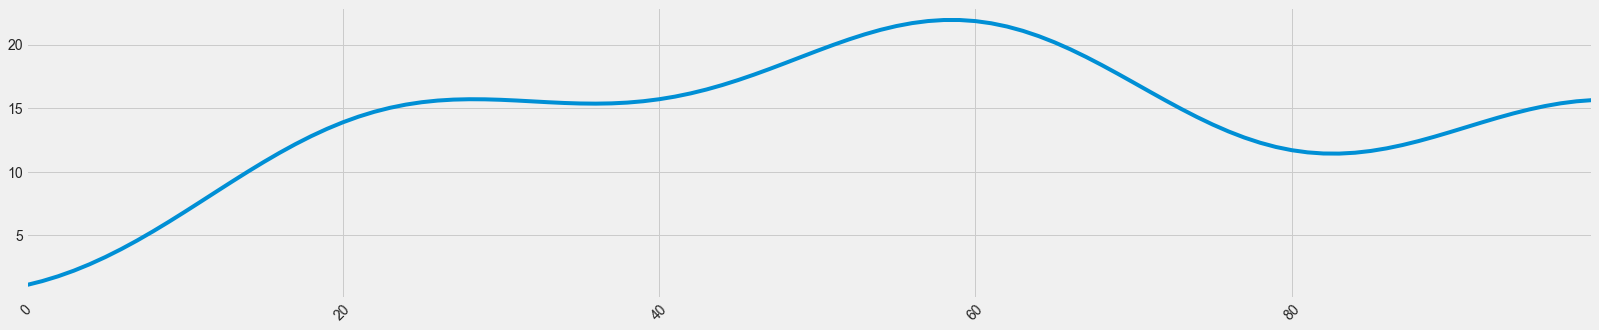

In [81]:
FIG['legend'] = False
pd.Series(X).plot(**FIG)

### Adapt Jockers' revised DCT function

Discrete Cosine Transform. A DCT is a Fourier-related transform similar to the discrete Fourier transform (DFT), but using only real numbers. This transformation was use in the paper to analyze the transformed plots as they don't show rolling.

In [82]:
def get_dct_transform(raw_values, low_pass_size = 5, x_reverse_len = 100):
    if low_pass_size > len(raw_values):
        raise ValueError("low_pass_size must be less than or equal to the length of raw_values input vector")
    values_dct = fftpack.dct(raw_values, type = 2)
    keepers = values_dct[:low_pass_size]
    padded_keepers = list(keepers) + list(np.zeros(x_reverse_len - low_pass_size))
    dct_out = fftpack.idct(padded_keepers)
    return(dct_out)

In [83]:
FFTCFG1 = dict(
    low_pass_size = 5,
    x_reverse_len = 100
)
X1 = get_dct_transform(by_sent[emo].values, **FFTCFG1)

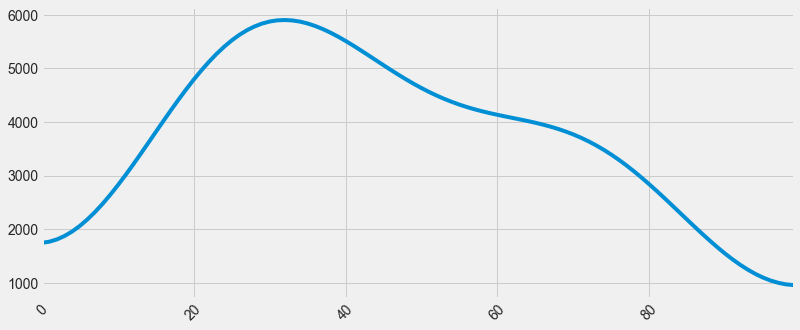

In [84]:
FIG['figsize'] = (12,5)
pd.Series(X1).plot(**FIG)

<img src="pers_rplot.jpg" width="900"/>

### Using Rolling
**Window types**: 
boxcar
triang
blackman
hamming
bartlett
parzen
bohman
blackmanharris
nuttall
barthann
kaiser (needs beta)
gaussian (needs std)
general_gaussian (needs power, width)
slepian (needs width).

In [85]:
# Config for tokens
CFG1 = dict(
    win_type='triang',
    window= int(tokens.shape[0]/ 9),
    center=True
)
CFG1['window']

9408

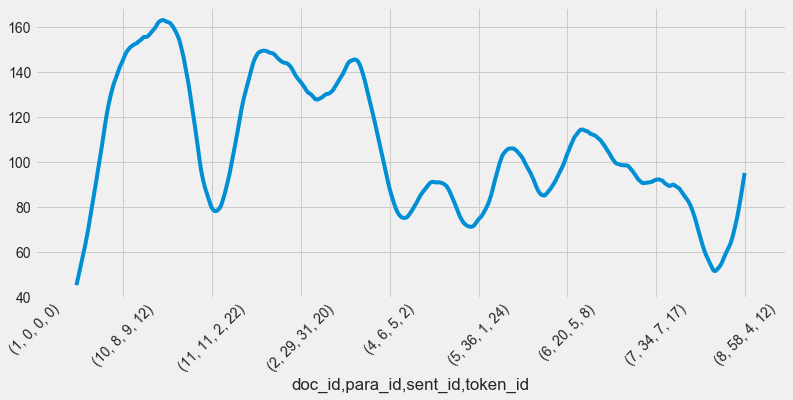

In [86]:
tokens[emo].fillna(0).rolling(**CFG1).sum().plot(**FIG)

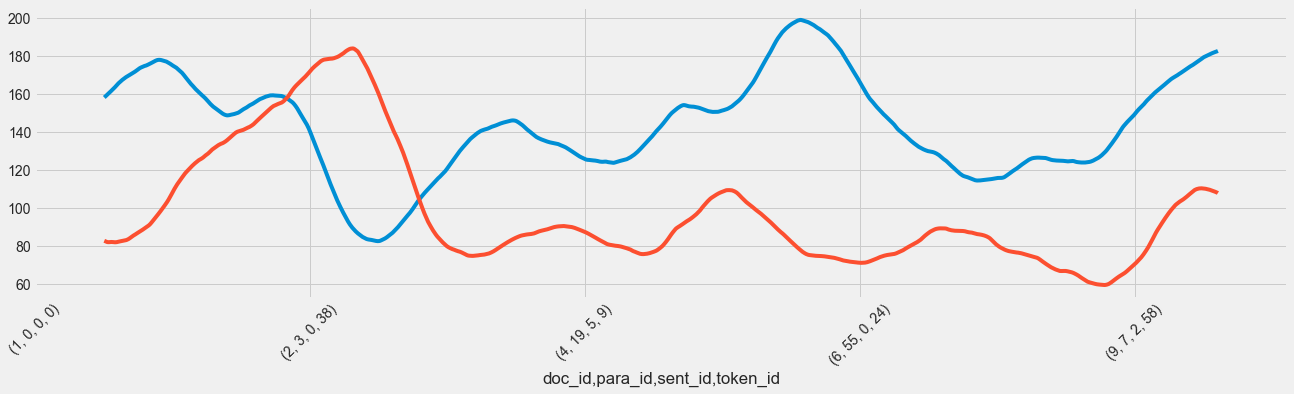

In [333]:
tokens[['nrc_positive','nrc_negative']].rolling(**CFG1).sum().plot(**FIG)
#legend is self-explainatory. blue being positive

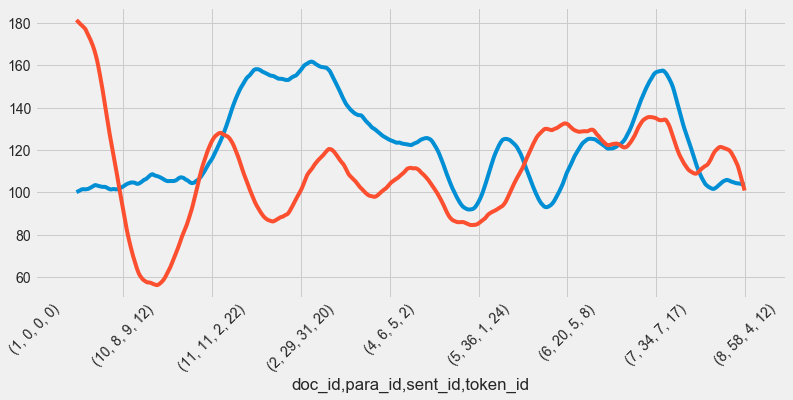

In [88]:
tokens[['bing_positive','bing_negative']].fillna(0).rolling(**CFG1).sum().plot(**FIG)

## Multinomial Emotions

In [89]:
EOM = tokens[emo_cols].reset_index(drop=True)

In [90]:
EOM.head()

,nrc_anger,nrc_anticipation,nrc_disgust,nrc_fear,nrc_joy,nrc_negative,nrc_positive,nrc_sadness,nrc_surprise,nrc_trust,bing_negative,bing_positive,bing_sentiment,syu_sentiment,gi_sentiment
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


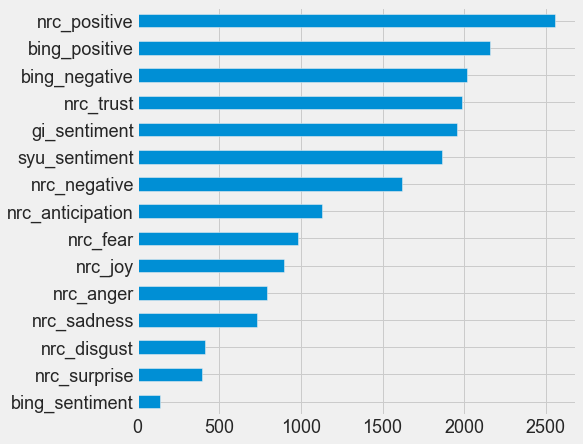

In [91]:
EOM.sum().sort_values().plot.barh(figsize=(7,7), fontsize=18)

As compared to corpus discussed in the paper this corpus is pretty positive for coal.

<img src="Coal_emotions.jpg" width="900"/>

### Shape data for Sklearn's KDE function

In [95]:
emo_offsets = []
for col in emo_cols:
    x = EOM[EOM[col] > 0].index.tolist()
    y = [[i] for i in x]
    emo_offsets.append((col, y))
B = pd.DataFrame(emo_offsets, columns=['emo', 'x'])
B = B.set_index('emo')

In [96]:
B

,x
emo,
nrc_anger,"[[6], [65], [81], [100], [106], [122], [158], ..."
nrc_anticipation,"[[17], [33], [48], [286], [304], [406], [414],..."
nrc_disgust,"[[236], [708], [730], [836], [1335], [1357], [..."
nrc_fear,"[[40], [65], [100], [187], [387], [423], [557]..."
nrc_joy,"[[33], [41], [278], [429], [453], [480], [553]..."
nrc_negative,"[[6], [40], [65], [81], [100], [106], [122], [..."
nrc_positive,"[[17], [33], [41], [48], [97], [223], [232], [..."
nrc_sadness,"[[65], [100], [279], [387], [423], [530], [570..."
nrc_surprise,"[[777], [847], [1357], [1919], [1939], [2597],..."


### Get KDE for each emotion

In [97]:
scale_max = EOM.shape[0]
kde_bandwidth = 2500
# kde_bandwidth = 250
x_axis = np.linspace(0, scale_max, kde_samples)[:, np.newaxis]
B['kde'] = B.apply(lambda row: KDE(kernel=kde_kernel, bandwidth=kde_bandwidth).fit(row.x), 1)
B['scores'] = B.apply(lambda row: row.kde.score_samples(x_axis), axis=1)
PLOTS = B.apply(lambda row: pd.Series(np.exp(row.scores) * (scale_max / kde_samples)), axis=1).T

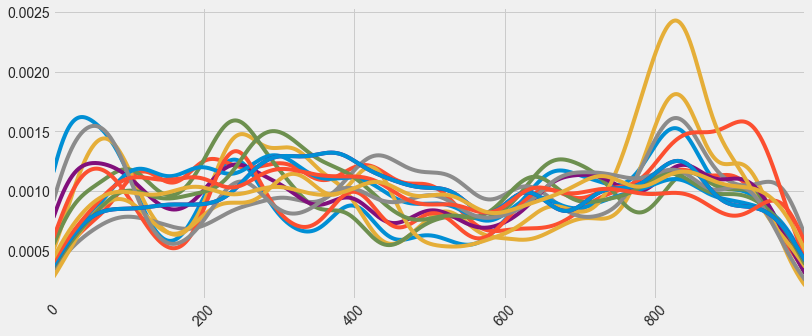

In [98]:
PLOTS.plot(**FIG)

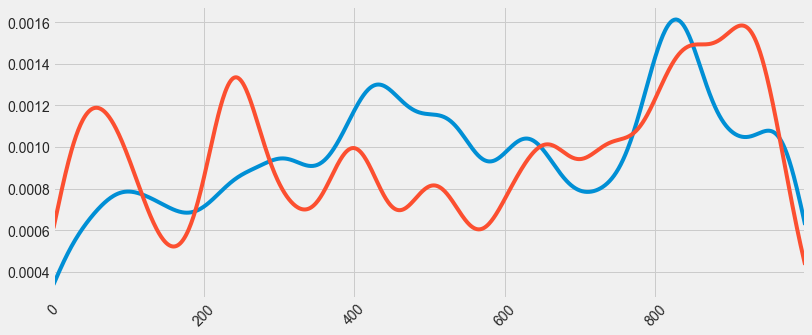

In [99]:
PLOTS[['nrc_joy','nrc_sadness']].plot(**FIG)

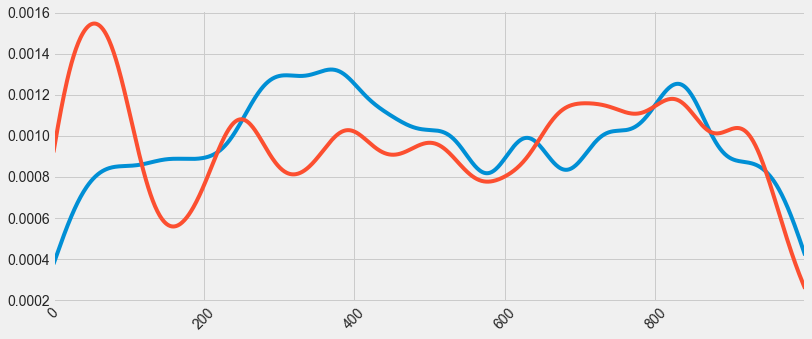

In [100]:
PLOTS[['bing_positive','bing_negative']].plot(**FIG)

### Compare KDE to Rolling graphs of Sentiment

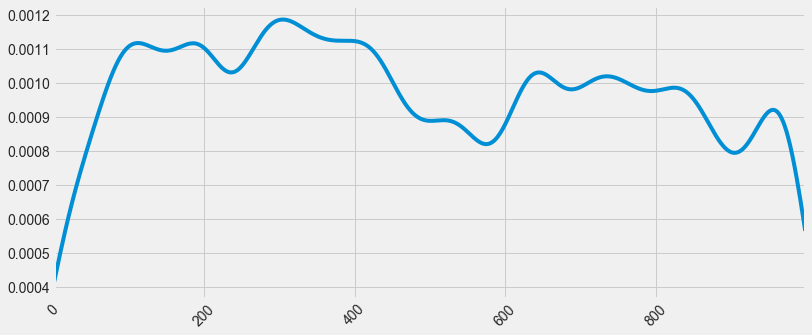

In [101]:
PLOTS[emo].plot(**FIG)

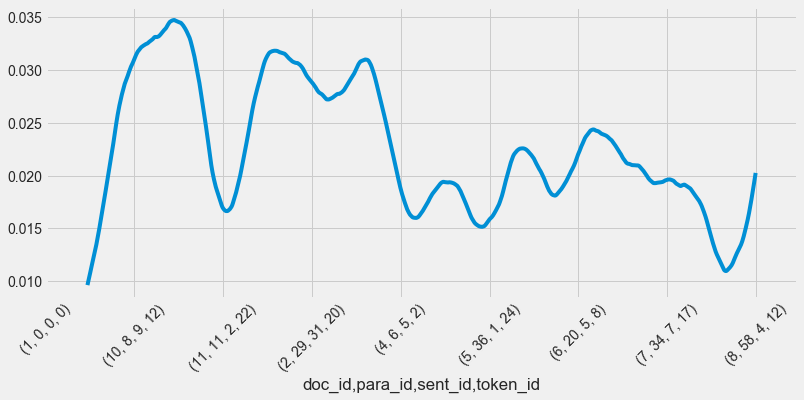

In [103]:
tokens[emo].fillna(0).rolling(**CFG1).mean().plot(**FIG)
#A bit more wavy

## Peak Negative

### Find max negative from PLOTS

In [104]:
PLOTS.head()

emo,nrc_anger,nrc_anticipation,nrc_disgust,nrc_fear,nrc_joy,nrc_negative,nrc_positive,nrc_sadness,nrc_surprise,nrc_trust,bing_negative,bing_positive,bing_sentiment,syu_sentiment,gi_sentiment
0,0.001159,0.000351,0.000505,0.000553,0.000338,0.000779,0.000403,0.000609,0.000281,0.000360,0.000919,0.000375,0.000375,0.000406,0.000441
1,0.001183,0.000360,0.000523,0.000568,0.000347,0.000797,0.000413,0.000626,0.000291,0.000370,0.000941,0.000385,0.000385,0.000417,0.000453
2,0.001207,0.000370,0.000540,0.000582,0.000355,0.000815,0.000423,0.000643,0.000301,0.000379,0.000962,0.000395,0.000395,0.000428,0.000464
3,0.001231,0.000379,0.000558,0.000596,0.000364,0.000832,0.000434,0.000660,0.000311,0.000389,0.000984,0.000405,0.000405,0.000438,0.000476
4,0.001254,0.000389,0.000576,0.000610,0.000372,0.000850,0.000444,0.000677,0.000321,0.000398,0.001005,0.000416,0.000416,0.000449,0.000487


In [105]:
PEAK_NEGATIVE = int((PLOTS['nrc_negative'].idxmax() / 1000) * tokens.shape[0])

In [106]:
PEAK_NEGATIVE_DOC_NUM = tokens.iloc[PEAK_NEGATIVE].name[0]

In [107]:
PEAK_NEGATIVE_DOC_NUM

'1'

### DisplayParagraphs

In [108]:
PEAK_NEGATIVE_PARA = tokens.loc[PEAK_NEGATIVE_DOC_NUM].groupby(['para_id']).token_str.apply(lambda x: ' '.join(x)).tolist()

In [110]:
display(HTML('<br/><br/>'.join(PEAK_NEGATIVE_PARA)))
#A lot about social and environemental risks of coal which makes sense.

## VADER

In [111]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [112]:
vader_cols = by_sent.sent_str.apply(analyser.polarity_scores).apply(lambda x: pd.Series(x))

In [113]:
by_sent = pd.concat([by_sent, vader_cols], axis=1)
by_sent.head()

nrc_anger  nrc_anticipation  nrc_disgust  nrc_fear  nrc_joy  \
para_id sent_id                                                                
0       0              3.0               6.0          0.0       1.0      4.0   
        1              1.0               4.0          0.0       2.0      3.0   
        2              7.0               2.0          2.0       5.0      2.0   
        3              4.0               5.0          1.0       4.0      4.0   
        4              2.0               3.0          3.0       4.0      4.0   

                 nrc_negative  nrc_positive  nrc_sadness  nrc_surprise  \
para_id sent_id                                                          
0       0                 4.0          11.0          2.0           1.0   
        1                 7.0           7.0          2.0           0.0   
        2                 8.0          11.0          2.0           0.0   
        3                 6.0          11.0          1.0           5.0   
        4                 8.0          10.0          2.0           0.0   

                 nrc_trust  ...  bing_positive  bing_sentiment  syu_sentiment  \
para_id sent_id             ...                                                 
0       0              9.0  ...            6.0            -1.0           4.85   
        1              4.0  ...            8.0             2.0           6.80   
        2             10.0  ...           15.0            -1.0          11.55   
        3              8.0  ...            3.0            -8.0           6.80   
        4              9.0  ...            4.0            -3.0           3.40   

                 gi_sentiment  \
para_id sent_id                 
0       0                 2.0   
        1                 5.0   
        2                 9.0   
        3                 1.0   
        4                 4.0   

                                                          sent_str  \
para_id sent_id                                                      
0       0        ï this article analyzes the coalmining opposit...   
        1        in the czech government established so called ...   
        2        the existence of these limits sparked a confli...   
        3        this article focuses on the discursive level o...   
        4        based on semi structured interviews conducted ...   

                                                          html_str    neg  \
para_id sent_id                                                             
0       0        <span class='sent0'>ï</span> <span class='sent...  0.056   
        1        <span class='sent0'>In</span> <span class='sen...  0.045   
        2        <span class='sent0'>The</span> <span class='se...  0.058   
        3        <span class='sent0'>This</span> <span class='s...  0.043   
        4        <span class='sent0'>Based</span> <span class='...  0.060   

                   neu    pos  compound  
para_id sent_id                          
0       0        0.812  0.132    0.9595  
        1        0.814  0.140    0.9826  
        2        0.847  0.095    0.9161  
        3        0.872  0.085    0.8494  
        4        0.821  0.119    0.9377  

[5 rows x 21 columns]

In [370]:
#Negative's magnitude is not the greatest for coal contradictory to the paper.
by_sent=by_sent.groupby(by_sent.columns, axis=1).agg(np.max)
by_sent.sort_values('neg', ascending=False).head(10)

,,bing_negative,bing_positive,bing_sentiment,compound,gi_sentiment,html_str,neg,neu,nrc_anger,nrc_anticipation,...,nrc_fear,nrc_joy,nrc_negative,nrc_positive,nrc_sadness,nrc_surprise,nrc_trust,pos,sent_str,syu_sentiment
para_id,sent_id,,,,,,,,,,,,,,,,,,,,,
30,18,0.0,0.0,0.0,-0.8074,-1.0,<span class='sent0'>Moreover</span> <span clas...,0.342,0.658,1.0,2.0,...,2.0,0.0,2.0,2.0,2.0,1.0,1.0,0.000,moreover after the nuclear accident in japan p...,-1.90
66,5,2.0,0.0,-2.0,-0.5499,-2.0,<span class='sent0'>But</span> <span class='se...,0.318,0.535,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.147,but under what circumstances will the leakage ...,-0.75
5,10,8.0,1.0,-7.0,-0.9477,-6.0,<span class='sent0'>More</span> <span class='s...,0.310,0.690,4.0,0.0,...,4.0,0.0,7.0,0.0,7.0,0.0,0.0,0.000,more specifically exposure to hydraulic fractu...,-7.35
3,12,1.0,0.0,-1.0,-0.6115,-1.0,<span class='sent0'>Specifically</span> <span ...,0.307,0.693,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.000,specifically liberals harbor more negative att...,-0.75
30,8,0.0,0.0,0.0,-0.7845,-2.0,<span class='sent0'>Attempts</span> <span clas...,0.301,0.699,1.0,0.0,...,2.0,0.0,2.0,0.0,1.0,0.0,0.0,0.000,attempts to mine uranium after world war ii in...,-1.00
3,10,1.0,0.0,-1.0,-0.4522,1.0,<span class='sent0'>Recent</span> <span class=...,0.270,0.730,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,recent studies have shed more light on conflic...,-0.75
52,6,1.0,0.0,-1.0,-0.0900,0.0,<span class='sent0'>It</span> <span class='sen...,0.260,0.505,1.0,1.0,...,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.235,it would be sinful not to use this opportunity,-0.25
50,7,4.0,1.0,-3.0,-0.8316,-1.0,<span class='sent0'>For</span> <span class='se...,0.260,0.700,0.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.040,for example there have been cases where oil co...,-3.50
22,10,1.0,0.0,-1.0,-0.3400,-1.0,<span class='sent0'>This</span> <span class='s...,0.255,0.745,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,this fire burns as high as this house,-0.65


In [114]:
CFG1['window'] = 50

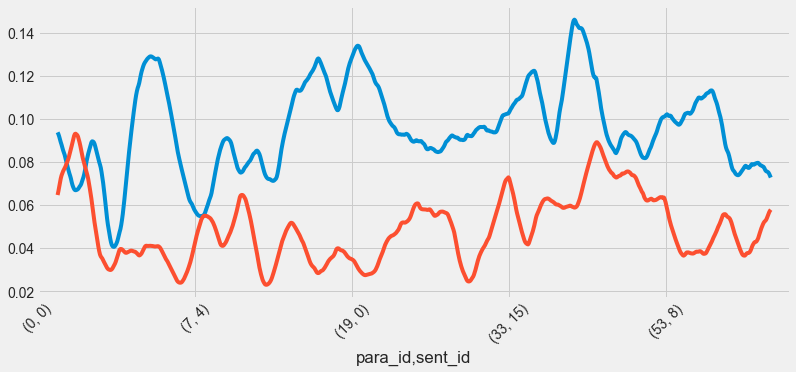

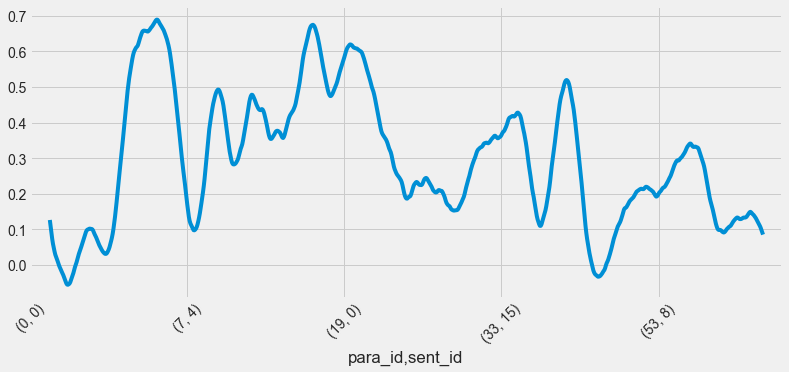

In [115]:
by_sent[['pos','neg']].rolling(**CFG1).mean().plot(**FIG)
by_sent[['compound']].rolling(**CFG1).mean().plot(**FIG)
#compoud shows the valence is positive for coal in the dataset.

## Compare KDE to Rolling Both Graphs of Syuzhet and VADER

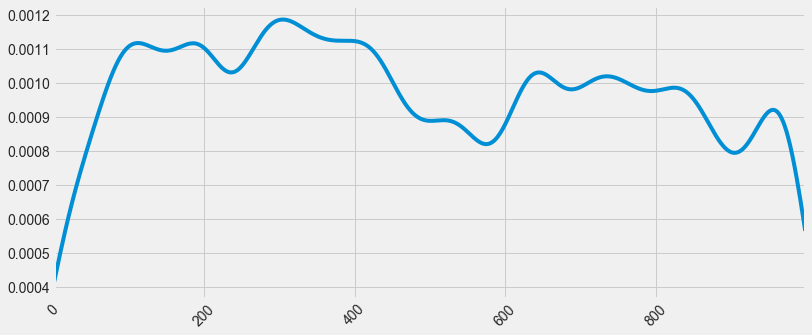

In [116]:
PLOTS[emo].plot(**FIG)

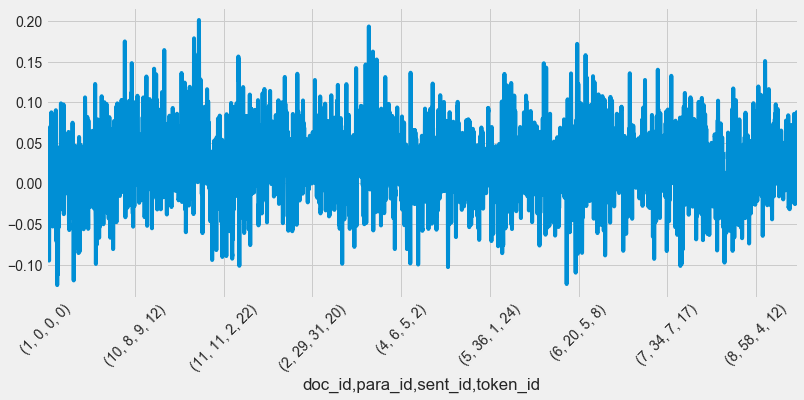

In [139]:
tokens[emo].fillna(0).rolling(**CFG1).mean().plot(**FIG)

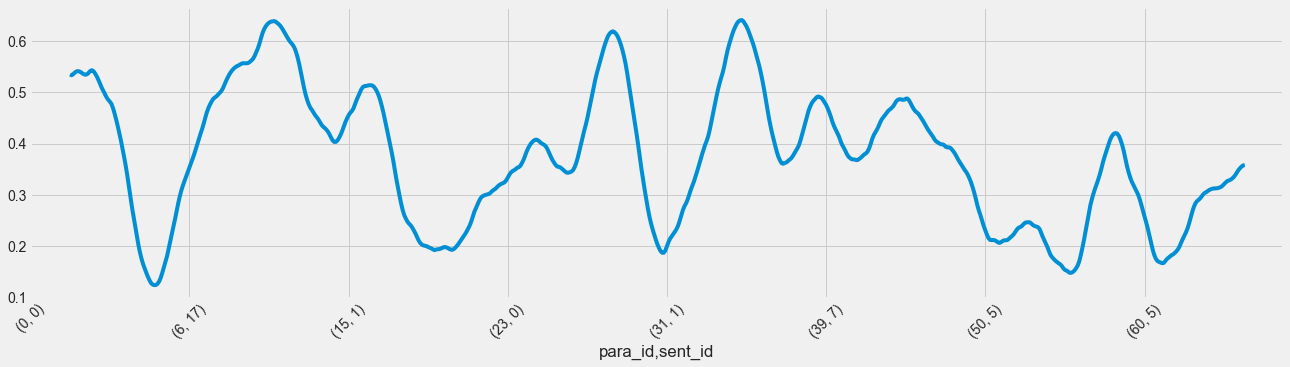

In [377]:
by_sent[['compound']].rolling(**CFG1).mean().plot(**FIG)

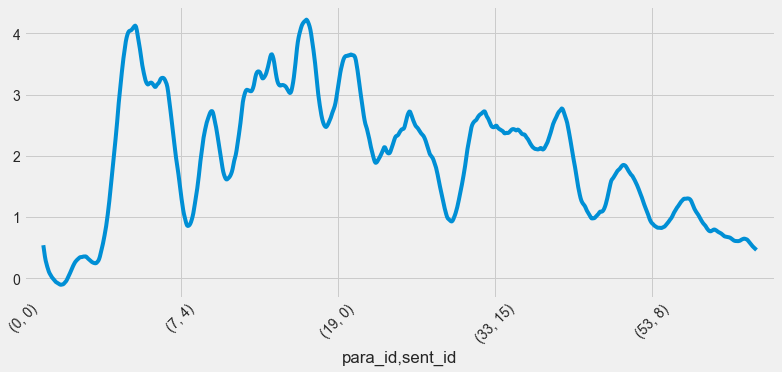

In [118]:
by_sent[emo].fillna(0).rolling(**CFG1).mean().plot(**FIG)

## Experimental Plotting Function

In [119]:
def  plot_sentiment(emo_col, type='sent'):
    if type == 'sent':
        by_sent[emo_col].fillna(0).rolling(**CFG1).mean().plot(**FIG)
    elif type == 'tokens':
        tokens[emo_col].fillna(0).rolling(**CFG2).mean().plot(**FIG)
    elif type == 'kde':
        PLOTS[emo_col].plot(**FIG)
    else:
        pass

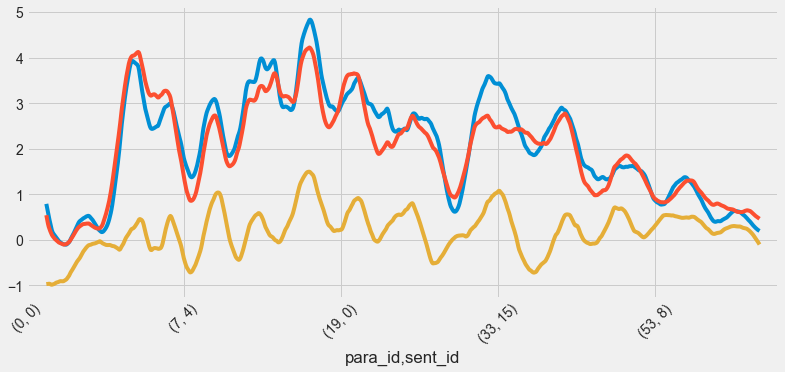

In [120]:
plot_sentiment('gi_sentiment')
plot_sentiment('syu_sentiment')
plot_sentiment('bing_sentiment')
#blue-gi
#red-syu
#yellow-bing

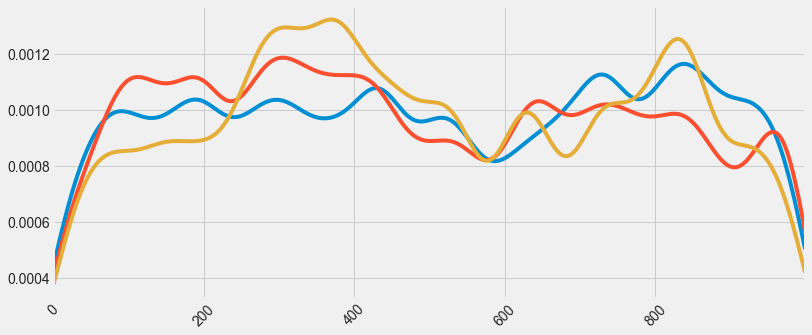

In [121]:
plot_sentiment('gi_sentiment', type='kde')
plot_sentiment('syu_sentiment', type='kde')
plot_sentiment('bing_sentiment', type='kde')